# Introduction to Reinforcement Learning (RL)

**Angela Radulescu**

New York Computational Psychiatry Workshop

Nov. 10th, 2025


Please start by making your own copy of this Google Colab notebook (you will need a Google account).

Today, we will learn how to use reinforcement learning (RL) to simulate behavior in different environments (tasks). This tutorial is intended to get you spinning up your own RL algorithms for a task of your choice. As we go along, we will go over both formal definitions and code.

Let us dive in! Go ahead and run the cell below to import some necessary packages.

In [111]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd

## What is reinforcement learning?

**Reinforcement learning (RL)** refers to a set of learning processes that allow agents to make adaptive decisions over time in order to achieve a **goal**. What makes RL different from other types of learning (e.g. supervised learning) is that the feedback used to change behavior (i.e., the **reinforcement**) can be:

1. **Sparse** -- reinforcement doesn't have to occur often
2. **Delayed** -- reinforcement can occur after many actions are taken
3. **Uncertain** -- an action may not always result in reinforcement

*Discussion question*: what are examples of RL that you have encountered in your work?

## Foundations

RL starts from the concept of an **agent** that is acting in an **environment**.

You can think of RL as a sort of "physics of behavior." It is a set of mathematical formulas that describe how intelligent agents interact with the *external* world. And how that interaction changes their *internal* world (e.g, desires, cognition, beliefs). 

At any given **timepoint** $t$, the agent can be in one of many **states** $s_t \in S$ of the environment, and decide to take one of many **actions** $a_t \in A$. Taking a particular action might switch the agent from $s_t$ to a new state $s_{t+1}$. Once an action is taken, the environment also responds with a reward $r_{t}$.

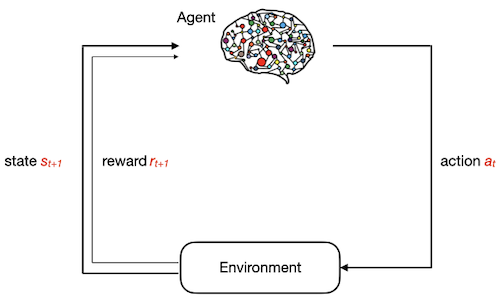

*Discussion question*: how would you define the states and actions of a decision-making scenario that you have encountered in your work?

### Environment

How the environment reacts to the agent's actions is defined by a **model**, which the agent may or may not know. The model has two main components: the transition function $T$ and the reward function $R$.

Let’s say when we are in state $s$, we decide to take action $a$ to arrive in the next state $s’$ and obtain reward $r$. We refer to this as a **transition** step, represented by a tuple $(s, a, s’, r)$. You can think of this tuple as a unit of experience that the agent gets to learn from.

The (repeated) tuples the agent will experience depend on how $T$ and $R$ are defined.

The transition function $T$ defines the probability of transitioning from state $s$ to state $s'$ after taking action $a$ while obtaining reward $r$ (here $\mathbb{P}$ stands for ``probability").

$$
P(s',r | s,a) = \mathbb{P}[S_{t+1} = s', R_{t} = r | S_t = s, A_t = a]
$$

The reward function $R$ predicts the next reward triggered by one action:

$$
R(s,a) = \mathbb{E}[R_{t+1} | S_t = s, A_t = a] = \sum\limits_{r \in R}r\sum\limits_{s' \in S}P(s',r|s,a)
$$

*Example*: let's unpack this some more using a simple "Corridor" environment depicted below.



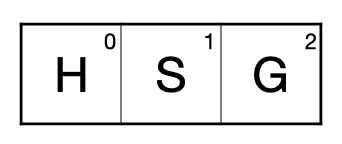

The "Corridor" environment has the following properties:

The state space consists of 3 states. The agent starts in State $1$ (Start), and can reach one of two **terminal** states, State $0$ (Hole) and State $2$ (Goal). When the agent reaches a terminal state, the **episode** (defined as a sequence of experience tuples) ends.

$$
s \in S = \{0, 1, 2\}
$$

The action space consists of two actions available to the agent: Action $0$ (Left) and Action $1$ (Right).

$$
a \in A = \{0, 1\}
$$

The "Corridor" has a **deterministic** transition function: a *Left* action always moves the agent to the left, and a *Right* action always moves the agent to the right.

The "Corridor" reward function gives a +1 when the agent moves into State $2$ (*Goal*) and 0 otherwise.

A convenient way to represent the model of the "Corridor" environment is in table form:

| State  | Action  | Next state  | Transition probability  | Reward  |
|-----------|-----------|-----------|-----------|-----------|
| 0 (Hole) | 0 (Left) | 0 (Hole) | 1  | 0 |
| 0 (Hole) | 1 (Right) | 0 (Hole) | 1  | 0 |
| 1 (Start) | 0 (Left) | 0 (Hole) | 1  | 0 |
| 1 (Start) | 1 (Right) | 0 (Goal) | 1  | +1 |
| 2 (Goal) | 0 (Left) | 2 (Goal) | 1  | 0 |
| 2 (Goal) | 1 (Right) | 2 (Goal) | 1  | 0 |

*Exercise*: Using the formula for the reward function above, compute the reward the agent would expect to get if it starts in the Start state and moves Right.

Let us now code up this environment. To define different components of our simulation, we will make use of [object oriented programming (OOP)](https://realpython.com/python3-object-oriented-programming/). OOP is helpful because it lets us define general classes we can reuse across different simulations to create new instances of each component (e.g. different instances of an agent, environment, etc).


In [113]:
class Corridor(object):

  """Class for the corridor environment."""

  def __init__(self):

    self.n_states = 3
    self.n_actions = 2
    self.states = np.arange(0, self.n_states)
    self.actions = np.arange(0, self.n_actions)
    self.reward_location = self.n_states

    self.state = 1 # begin in Start state
    self.t = 0     # reset timstep
    self.terminate = False

  def visualize(self):

    print("Green is the Goal state")

    xs = np.arange(0, self.n_states+1, 1)
    ys = np.arange(0, 2)

    fig, ax = plt.subplots(1, 1, figsize=(self.n_states,1))
    # grid "shades" (boxes)
    w, h = xs[1] - xs[0], ys[1] - ys[0]
    for i, x in enumerate(xs[:-1]):
        for j, y in enumerate(ys[:-1]):
            if (i == self.reward_location - 1):
                ax.add_patch(Rectangle((x, y), w, h, fill=True, color='#008610', alpha=.1))
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color='black', alpha=.33, linestyle=':')
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color='black', alpha=.33, linestyle=':')

    ax.set_xticks(xs[:-1]+0.5)
    ax.set_xticklabels(xs[:-1]+1)
    ax.set_yticklabels([])
    ax.set_xlabel('State', fontsize=15)

    plt.tick_params(left = False)
    plt.show()

  def step(self, action):

    # the step method takes as input a state and action and changes the environment
    # this is where we encode the environment's true model (T and R)

    assert self.state in self.states, "Invalid state"
    assert action in self.actions, "Invalid action"

    if self.state == 1:
      print('New episode')

    print('Current state: ' + str(self.state))

    if action == 0:
      print('Action: left')
    else:
      print('Action: right')

    if self.state == 1:

        if action == 0:    # agent picks left
            self.state = 0
            reward = 0
        else:              # agent picks right
            self.state = 2
            reward = 1
        self.terminate = 1
        print('+ ' + str(reward) + ' reward')

    elif self.state == 0:
        self.state = 0
        reward = 0
        self.terminate = True
        print('+ ' + str(reward) + ' reward')

    elif self.state == 2:
        self.state = 2
        reward = 0
        self.terminate = True
        print('+ ' + str(reward) + ' reward')

    print('New state: ' + str(self.state))

    # increment timestep
    self.t = self.t + 1
    if self.terminate == True:
      self.reset()
      print('End of episode')

    return self.state, reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.state = 1
    self.terminate == False

Green is the Goal state


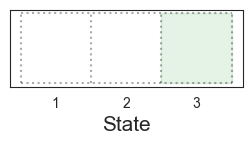

In [114]:
# This line creates an instance of the Corridor class
env = Corridor()

env.visualize()

In [115]:
# This line takes an action and steps through the environment
new_state, reward = env.step(1)

New episode
Current state: 1
Action: right
+ 1 reward
New state: 2
End of episode


Some transition functions are **probabilistic**, meaning that the same action can lead to different states with different probabilities.

*Exercise*: How would you modify the Corridor environment's step function to encode a transition function in which an action works as intended 80% of the time, but 20% of the time the agent "slips" and an action takes the agent to the opposite state?

We may or may not know how the model works and this differentiates two types of RL:

1.   **Model-based RL** - rely on the model of the environment to decide how to act; know the model in advance, or learn it from experience  
2.   **Model-free RL** - no dependency on the model during learning and action selection

Together, these elements (state space $S$, action space $A$, transition function $T$ and reward function $R$) define a **Markov Decision Process (MDP)**. You can think of the MDP as an abstract definition of a particular **task** an agent has to solve.

*Discussion question*: what are some examples of tasks that come to mind which can be thought of in this way?

All states in an MDP have the “Markov” property, referring to the fact that the future only depends on the current state, not the history. Or, in other words, the future and the past are conditionally independent given the present, as the current state encapsulates all the statistics we need to decide the future. This is one of the main **assumptions** of RL (assumption = what we take to be true from the start).   

### Agent

Another key assumption of RL is that an agent's objective is to maximize long term future reward. This future reward is known as **return**, and it is defined as the total sum of discounted rewards going forward:

$$
G_t = R_{t+1} + \gamma R_{t+2} + ...  = \sum\limits_{k = 0}^{\infty} \gamma^k R_{t+k+1}
$$

The discount factor $\gamma \in [0, 1]$ downweights rewards in the future. It is there for mathematical convenience (we don't need to track future steps forever to compute a return), but also has an interesting psychological interpretation -- we know humans tend to discount benefits that are not immediate.

The agent's **behavior** is represented by a **policy** $\pi$ which encodes what action to take in each state $s$. You can think of this as a function that maps between states and action. This mapping can be either deterministic (always take the same action in a state) or stochastic (take different actions with different probabilities):

$$
\text{Deterministic}: \pi(s) = a
$$

$$
\text{Stochastic}: \mathbb{P}_\pi[A = a|S = s]
$$


### Value

Most RL algorithms in the literature rely on the concept of **value**. Value measures the general "goodness" of a **state** or **state-action** pair: how good is it to be in a state, or how good is it to be in a state and do an action? You can think of these two types of value as mapping onto Pavlovian and instrumental control. From this perspective, Pavlovian learning refers to learning reward predictions; instrumental learning refers to learning what to do, given reward predictions.   

The state-value of a state $s$ is the expected return if we are in this state at time $t$, $S_t = s$:

$$
V_{\pi}(s) =  \mathbb{E}_\pi[G_t | S_t = s]
$$

Similarly, we define the action-value ("Q-value") of a state-action pair as:

$$
Q_{\pi}(s,a) =  \mathbb{E}_\pi[G_t | S_t = s, A_t = a]
$$

By definition, the optimal value function produces the maximum return:

$$
V_*(s) = \max\limits_{\pi}V_{\pi}(s)
$$

$$
Q_*(s, a) = \max\limits_{\pi}Q_{\pi}(s, a)
$$

And the optimal policy achieves the optimal value functions:

$$
\pi_* = \underset{\pi}{\mathrm{argmax}} \ V_\pi(s)
$$

$$
\pi_* = \underset{\pi}{\mathrm{argmax}} \ Q_\pi(s,a)
$$

Most RL algorithms you will encounter in the computational psychiatry literature assume reward maximization defined as above, and aim to have the agent (e.g. human participants, rodents, monkeys) learn the optimal value function and/or the optimal policy. While this discussion is beyond the scope of our tutorial, the limits of this assumption is a matter of active debate in cognitive science ([Juechems & Summerfield](https://arxiv.org/pdf/2407.10583)) and AI ([Silver et al.](https://www.sciencedirect.com/science/article/pii/S0004370221000862), [Abel et al.](https://rlj.cs.umass.edu/2024/papers/RLJ_RLC_2024_89.pdf)).


### Bellman equations

The **Bellman equations** are a set of recursive update equations that, given complete information of the environment, can be used to directly compute value functions.  These equations decompose the value function into the immediate reward plus the discounted future values.

#### Expectation equations

$$
V_\pi(s) = \sum\limits_{a \in A} \pi(a | s) (R(s,a) + \gamma  \sum\limits_{s' \in S}P_{s,s'}^aV_\pi(s'))
$$

Unpacking the terms:
* $V_\pi(s)$ = the value of state $s$ when following policy $\pi$
* $\pi(a|s)$ = the probability of choosing action $a$ in state $s$
* $R(s,a)$ = the immediate reward obtained after taking action $a$ in state $s$
* $\gamma$ = discount factor
* $P_{s,s'}^a$ = probability of ending up in $s'$ after taking action $a$ in *s*
* $V_\pi(s')$ = the value of state $s'$ when following policy $\pi$

*Discussion question*: does this logic make intuitive sense? Why or why not?

We can write the same kind of relationship for the **state-action value**:

$$
Q_\pi(s,a) = R(s,a) + \gamma   \sum\limits_{s' \in S}P_{s,s'}^a \sum\limits_{a' \in A} \pi(a',s')Q_\pi(s',a')
$$

* $Q_\pi(s,a)$ = the value of taking action $a$ state $s$ when following policy $\pi$
* $R(s,a)$ = the immediate reward obtained after taking action $a$ in state $s$
* $\gamma$ = discount factor
* $P_{s,s'}^a$ = probability of ending up in $s'$ after taking action $a$ in *s*
* $\pi(a|s)$ = the probability of choosing action $a$ in state $s$
* $Q_\pi(s',a')$ = the value of taking action $a'$ state $s'$ when following

*Discussion question*: how does this differ from the state value Bellman equation?

#### Optimality equations

If we are only interested in the **optimal policy**, rather than computing the expectation following any policy, we can modify the expectation equations slightly to compute the maximum returns:

$$
V_*(s) = \max\limits_{a \in A}(R(s,a) + \gamma  \sum\limits_{s' \in S}P_{s,s'}^a V_*(s'))
$$

$$
Q_*(s,a) = R(s,a) + \gamma \sum\limits_{s' \in S} P_{s,s'}^a \max\limits_{a' \in A} Q_*(s',a')
$$

*Discussion question*: these look very similar to the expectation equations, with a few important differences. What are these differences, and what do they mean for the agent's behavior?

#### Dynamic programming

In most scenarios, directly applying the Bellman equations to solve MDPs is impractical. Nevertheless, these equations lay the theoretical foundation for many RL algorithms. For small state and actions spaces, we can use **dynamic programming** to solve the equations and determine the optimal policy. This can be useful, for instance in understanding how the value function of an agent might change under different assumptions about the problem.

*Discussion question*: why would dynamic programming be impractical for large state and action spaces?

*Example paper*: [Zorowitz et al.](https://pubmed.ncbi.nlm.nih.gov/34036174/) used this technique to show how anxious symptomatology can result from relaxing the assumption that the agent makes the return-maximizing choice at each step (as shown in the Bellman optimality equation above).

## Classic RL algorithms

We will now discuss two of the most widely used RL algorithms in the literature: **Temporal-Difference Learning** and **Q-Learning**. While remarkably simple, these algorithms have been extensively studied because of the wealth of evidence suggesting that the brain is implementing this form RL (for a detailed discussion, see this review by [Niv](https://www.sciencedirect.com/science/article/pii/S0022249608001181#fig3)).

### TD-Learning

Temporal-Difference Learning is a general purpose algorithm for learning reward predictions which guarantees convergence to the optimal value function in any MDP. It embodies the key intuition of RL, which is using experience to update reward expectations.

The update equation for TD-Learning is as follows:

$$
V(S_{t}) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]
$$

Unpacking the terms:
* $V(S_t)$ = value of current state
* $V(S_{t+1})$ = value of future state
* $0 < \alpha < 1$ = learning rate  
* $R_{t+1}$ = immediate reward
* $\gamma$ = discount factor



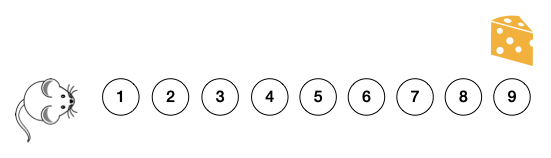

Let us now implement TD-Learning for a simple environment. Consider a mouse running along a track until it reaches a terminal state where it encounters a piece of cheese. We can abstract this as a "single track" in which the agent doesn't take any actions, but simply moves forward on the track.

In [116]:
class SingleTrack(object):

  """Class for the single track environment.

  Parameters
  ----------
  n_states : int
      Number of states on the track.

  """

  def __init__(self, n_states):

    self.n_states = n_states
    self.states = np.arange(0, n_states)
    self.reward_location = self.n_states

    self.state = 1 # begin in Start state
    self.t = 0     # reset timstep
    self.terminate = False

  def visualize(self):

    xs = np.arange(0, self.n_states+1, 1)
    ys = np.arange(0, 2)

    fig, ax = plt.subplots(1, 1, figsize=(self.n_states,1))
    # grid "shades" (boxes)
    w, h = xs[1] - xs[0], ys[1] - ys[0]
    for i, x in enumerate(xs[:-1]):
        for j, y in enumerate(ys[:-1]):
            if (i == self.reward_location - 1):
                ax.add_patch(Rectangle((x, y), w, h, fill=True, color='#f9b02e', alpha=.8))
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color='black', alpha=.33, linestyle=':')
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color='black', alpha=.33, linestyle=':')

    ax.set_xticks(xs[:-1]+0.5)
    ax.set_xticklabels(xs[:-1]+1)
    ax.set_yticklabels([])
    ax.set_xlabel('State', fontsize=15)

    plt.tick_params(left = False)
    plt.show()

  def step(self):

    print('Current state: ' + str(self.state))
    print('Moving right...')
    self.state = self.state+1

    if (self.state == self.reward_location):
        reward = 10;
        self.terminate = True
    else:
        reward = 0;

    print('New state: ' + str(self.state))

    # increment timestep
    self.t = self.t + 1

    return self.state, reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.state = 1
    self.t = 0     # reset timstep
    self.terminate = False


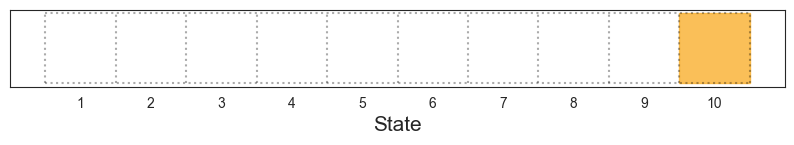

In [118]:
track = SingleTrack(10)
track.visualize()

Time to code up our first agent!

In [120]:
class TDRL(object):
  """Class for the TDRL reward prediction algorithm.

  Parameters
  ----------

  alpha : float, range (0, 1)
      Learning rate.

  gamma : float, range (0, 1)
      Discount factor.

  """

  def __init__(self, env, alpha, gamma, v_init = False):

    self.a = alpha
    self.g = gamma

    # initialize values
    if v_init: # check if initial values were provided
      self.v = np.ones((env.n_states, ))*v_init
    else:
      self.v = np.zeros((env.n_states, ))

    # initialize td-errors
    self.d = np.zeros((env.n_states, ))

  def update(self, current_state, new_state, reward, verbose=False):

    td_error = reward + self.g * self.v[new_state-1] - self.v[current_state-1]

    print('delta: ' + str(td_error))

    self.d[current_state] = td_error
    self.v[current_state-1] = self.v[current_state-1] + self.a * td_error

    if verbose == True:
      print('delta: ' + str(self.v))

It is often convenient to write a simulation function that has the agent and environment interact for a fixed number of trials or episodes.

In [121]:
def run_simulation(params, n_episodes):

  """Function for running a simulation of TDRL in the single track environment."""

  # make environment
  env = SingleTrack(params['n_states'])

  # initialize agent
  agent = TDRL(env, params['alpha'], params['gamma'])

  # initialize output containers
  V = np.zeros((n_episodes, params['n_states']))
  D = np.zeros((n_episodes, params['n_states']))

  for e in np.arange(n_episodes):

    print("Ran the track " + str(e) + " times so far")

    for s in np.arange(params['n_states']):

      # step through environment
      current_state = env.state
      _, reward = env.step()
      new_state = env.state

      # update agent
      agent.update(current_state, new_state, reward, verbose=False)

      if env.terminate:

          V[e,:] = agent.v
          D[e,:] = agent.d

          print('End of episode')
          env.reset()

          break

  return env, V, D

In [124]:
n_episodes = 100

params = {
    'n_states': 10,
    'alpha': 0.2,
    'gamma': 0.9
}

env, V, D = run_simulation(params, n_episodes)

Ran the track 0 times so far
Current state: 1
Moving right...
New state: 2
delta: 0.0
Current state: 2
Moving right...
New state: 3
delta: 0.0
Current state: 3
Moving right...
New state: 4
delta: 0.0
Current state: 4
Moving right...
New state: 5
delta: 0.0
Current state: 5
Moving right...
New state: 6
delta: 0.0
Current state: 6
Moving right...
New state: 7
delta: 0.0
Current state: 7
Moving right...
New state: 8
delta: 0.0
Current state: 8
Moving right...
New state: 9
delta: 0.0
Current state: 9
Moving right...
New state: 10
delta: 10.0
End of episode
Ran the track 1 times so far
Current state: 1
Moving right...
New state: 2
delta: 0.0
Current state: 2
Moving right...
New state: 3
delta: 0.0
Current state: 3
Moving right...
New state: 4
delta: 0.0
Current state: 4
Moving right...
New state: 5
delta: 0.0
Current state: 5
Moving right...
New state: 6
delta: 0.0
Current state: 6
Moving right...
New state: 7
delta: 0.0
Current state: 7
Moving right...
New state: 8
delta: 0.0
Current state

To visualize our results, we can plot the value function:

In [1]:
# Value
df_wide = pd.DataFrame(V.T)
df_wide.loc[len(df_wide.index)-1] = 10

fig, ax = plt.subplots(1,1,figsize=(9,4))
sns.lineplot(data=df_wide, legend=False, palette='Blues', markers=True, dashes=False)
ax.legend(labels=list(np.arange(params['n_states'])+1))
ax.axvline(x=params['n_states']-1, color='blue',linewidth=4)
ax.set_xticks(np.arange(params['n_states']))
labels = [str(i) for i in np.arange(params['n_states'])+1]
labels[-1] = 'R'
ax.set_xticklabels(labels)
ax.set_xlabel('State',fontsize=15);
ax.set_ylabel('Value',fontsize=15);
sns.set_style('white');
sns.despine();
plt.gca().get_legend().remove()

# TD-error
df_wide = pd.DataFrame(D.T)

fig, ax = plt.subplots(1,1,figsize=(9,4))
sns.lineplot(data=df_wide, legend=False, palette='Greens', markers=True, dashes=False)
ax.legend(labels=list(np.arange(params['n_states'])+1))
ax.axvline(x=params['n_states']-1, color='green',linewidth=4)
ax.set_xticks(np.arange(params['n_states']))
labels = [str(i) for i in np.arange(params['n_states'])+1]
labels[-1] = 'R'
ax.set_xticklabels(labels)
ax.set_xlabel('State',fontsize=15);
ax.set_ylabel('Reward prediction error',fontsize=15);
sns.set_style('white');
sns.despine();
plt.gca().get_legend().remove()

env.visualize()

NameError: name 'pd' is not defined

One nice intuition for what TD-Learning does is “backing up errors”.
Each line on the value plot  shows you what happens to the value of states preceding the reward when we apply TD-Learning over many episodes (darker lines mean later episodes).  

In early episodes, only the value of states immediately before the reward becomes positive (because that state predicts the imminent reward).

But as the agent experiences this track more and more times, the error gets propagated backwards to earlier states in the track — they each acquire a bit of predictive value.

This is exactly how we think conditioning works: if you walk multiple times to your favorite restaurant and take the same route, in time, you will learn to predict that different parts of your route (like a park or a street corner) lead to reward.

*Discussion question*: What happens to the reward prediction error as the agent experiences the track multiple times? Why?  

*Exercise*: Suppose reward was omitted on a random episode during the task. What do you think would happen to the RPE when the agent reaches the last state during that episode? You can verify your intuition in simulation by modifying the code above. This is exactly the experiment that led to the **[reward prediction error hypothesis](https://www.science.org/doi/10.1126/science.275.5306.1593)** of dopamine function. For a current view of this topic, see this [review](https://www.nature.com/articles/s41593-024-01705-4) by Gershman et al.

### Q-Learning

The TD-Learning algorithm tells us how to update our predictions, but does not tell us how to act. It is possible to extend the logic of learning from temporal differences to estimate $q_\pi(s, a)$ which is the state-action value function for a particular policy.

In fact, if it turns out that if we make the additional assumption that the agent's policy is to simply choose the best action *at the current timestep*, we end up with an update algorithm that [provably](https://link.springer.com/article/10.1007/BF00992698) converges to the optimal policy with enough experience. This is known as **Q-Learning**, and proceeds as follows:

Within one episode, Q-Learning works as follows:

1. Initialize $t = 0$
2. Start in $S_0$
3. At time step $t$, pick the action $A_t$ with the largest Q-Value.
4. After applying action $A_t$, we observe reward $R_{t+1}$ and encounter the next state $S_{t+1}$.
5. Update the Q-value function according to:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + \gamma \max\limits_{a}Q(S_{t+1},a) - Q(S_t,A_t)]
$$

6. $t = t+1$ and repeat from Step 3.

In the next section, we will show how we can take Q-Learning and turn it into a model of human behavior which we can test against behavioral data.



## From RL algorithms to modeling human behavior

### Simulating behavior

To see how we can apply these ideas to modeling human behavioral data, let's consider a simple environment in which on each trial $t$, a participant makes a choice $c_t$ (= Left or Right) between a left and a right slot machine, and receives a reward $r_t$ (= $\$1$ or $\$0$) stochastically with probability $0.8$ if it chooses Left, or with probability $0.2$ if it chooses Right. This environment is called a **2-armed bandit**.

Let's code up this environment below:

In [128]:
class Bandit(object):

  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms (actions).
  best_action: int
      Best action.
  p_best : float, range (0, 1)
      Reward probability for the best action.
  p_other: float, range (0, 1)
      Reward probability for the other arms.

  """

  def __init__(self, k, best, p_best, p_other, labels=None):

    self.k = k              # number of arms
    self.best_action = best # best action
    self.p_best = p_best    # probability of reward for best action
    self.p_other = p_other  # probability of reward for other actions
    self.t = 0              # initialize timestep
    self.labels = labels

  def visualize(self):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm

    p_reward = np.ones((self.k, ))*self.p_other
    p_reward[self.best_action-1] = self.p_best

    sns.barplot(p_reward)
    if self.labels == None:
      labels = np.arange(self.k)+1
    else:
      labels = self.labels
    plt.xticks(np.arange(self.k), labels)
    plt.xlabel('Action')
    plt.ylabel('Reward probability')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    if action == self.best_action:
      reward = np.random.choice([1,0], p=[self.p_best, self.p_other])
    else:
      reward = np.random.choice([1,0], p=[self.p_other, self.p_best])

    # increment timestep
    self.t = self.t + 1

    # comment the next line in if you want to print the time step
    # print('timestep: ' + str(self.t))

    return reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.t = 0

*Exercise*: Use the bandit class to instantiate a four-armed bandit in which the probability of reward for taking the best action is 0.8, and 0.2 otherwise. Visualize to verify.

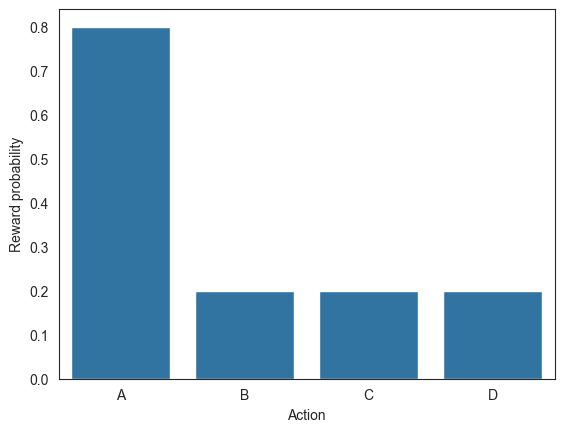

In [129]:
fourarmed = Bandit(4, 1, 0.8, 0.2, labels=['A', 'B', 'C', 'D'])
fourarmed.visualize()

Now let's code up the Q-Learning agent:

In [131]:
class QLearning(object):
  """Class for the Q-learning algorithm.

  Parameters
  ----------

  alpha : float, range (0, 1)
      Learning rate.

  gamma : float, range (0, inf)
      Discount factor.

  beta : float, range (0, 1)
      Inverse temperature.

  """

  def __init__(self, env, alpha, beta, epsilon, q_init=False):

    # initialize action space
    self.action_space = env.action_space

    self.a = alpha
    self.b = beta
    self.eps = epsilon

     # initialize Q-values
    if q_init: # check if initial q-values were provided
      self.q = np.ones((env.n_states+1, env.k))*q_init
    else:
      self.q = np.zeros((env.n_states+1, env.k))

  def softmax(self, q_values):
    """Compute softmax probabilities for a vector of Q-values."""
    # numerical stability trick: subtract max
    q_stable = q_values - np.max(q_values)
    exp_q = np.exp(q_stable / self.beta)
    return exp_q / np.sum(exp_q)

  def policy(self, state):
    """Select action according to Softmax probabilities."""
    probs = self.softmax(self.q[state-1])
    action = np.random.choice(np.arange(1, len(probs)+1), p=probs)
    return action

  def update(self, current_state, action, reward, new_state, verbose=False):

    # we are at the start door
    if current_state == 1:

        # model-free learning
        self.q[current_state-1, action-1] = self.q[current_state-1, action-1] + self.a*(reward + self.g * max(self.q[new_state-1, :]) - self.q[current_state-1, action-1])

    # we are at one of the second doors
    elif (current_state == 2) | (current_state == 3):

      # model-free learning
      self.q[current_state-1, action-1] = self.q[current_state-1, action-1] + self.a*(reward + self.g * max(self.q[new_state-1, :]) - self.q[current_state-1, action-1])

    if verbose == True:
      print(self.q)


### The likelihood function

In a typical experiment, our data consists of stimuli, participant choices, and outcomes. The likelihood function is the statistical model that allows us to relate the algorithm to the data we observe. In general, if the data generated by an RL algorithm matches the data we obtain from our participants, we say that the algorithm is a good description of the cognitive process. 

We need a mathematical way to specify how to link between variables of the algorithm and choice data. The most common *link function* is the softmax [[1]](https://www.princeton.edu/~ndaw/d10.pdf)[[2]](https://elifesciences.org/articles/49547). 

Let us now implement that in code using the QLearning class we defined above.

In [ ]:
import numpy as np

def qlearning_choice_loglik(
    agent,
    states,          # array-like, int, 1..n_states
    actions,         # array-like, int, 1..k  (1-based indexing)
    rewards,         # array-like, numeric
    next_states,     # array-like, int, 1..n_states
    beta,            # float, inverse temperature for softmax
    include_mask=None,   # optional bool array, True to include that trial in the likelihood
    init_q=None,         # optional float to (re)initialize agent.q before rolling; if None, keep current
    return_per_trial=False,
):
    """
    Softmax observation model likelihood.

    Likelihood per trial t:
        P(a_t | s_t, Q, beta) = exp(beta * Q[s_t, a_t]) / sum_a exp(beta * Q[s_t, a])

    Then the agent learns from the observed (s_t, a_t, r_t, s'_t) via agent.update(...).

    Parameters
    ----------
    agent : QLearning
        Your QLearning instance (has .q with shape (n_states+1, k), 1-based states/actions).
    states, actions, rewards, next_states : same length arrays
        Observed data. Use -1 or np.nan in `actions` to skip a trial (no likelihood, no update).
    beta : float
        Softmax inverse temperature.
    include_mask : None or array-like of bool
        If provided, only trials with mask==True contribute to likelihood and updates
        (useful if you only want, e.g., first-step choices: include_mask = (states == 1)).
    init_q : None or float
        If given, fills agent.q with this value before rolling forward.
        If None, uses agent.q as-is.
    return_per_trial : bool
        If True, also return vector of per-trial log-probs (np.nan for skipped).

    Returns
    -------
    total_loglik : float
    (optional) per_trial_logp : np.ndarray
    """
    states      = np.asarray(states)
    actions     = np.asarray(actions)
    rewards     = np.asarray(rewards)
    next_states = np.asarray(next_states)
    assert len(states) == len(actions) == len(rewards) == len(next_states), "All inputs must be same length"

    # Optionally (re)initialize Q-table to a known baseline
    if init_q is not None:
        agent.q[:] = init_q

    T = len(actions)
    per_logp = np.full(T, np.nan, dtype=float)

    # Determine action-space size (k) from the Q-table’s second dimension
    # agent.q shape is (n_states+1, k)
    k = agent.q.shape[1]

    # Trials to include
    if include_mask is None:
        include_mask = np.ones(T, dtype=bool)
    else:
        include_mask = np.asarray(include_mask, dtype=bool)
        assert include_mask.shape == (T,), "include_mask must match number of trials"

    for t in range(T):
        if not include_mask[t]:
            continue

        a = actions[t]
        s = states[t]
        ns = next_states[t]
        r = rewards[t]

        # Skip trial if action is missing/invalid
        if (a is None) or (isinstance(a, float) and np.isnan(a)) or (int(a) < 1):
            continue

        # Pull Q-values for current state (remember your table is 1-based for states)
        # agent.q shape: (n_states+1, k), so state s maps to row s-1
        Qs = np.asarray(agent.q[s-1, :], dtype=float)   # length k

        # Numerically stable log-softmax
        z = beta * Qs
        z -= np.max(z)
        log_denom = np.log(np.exp(z).sum())
        chosen_idx = int(a) - 1     # 1..k -> 0..k-1
        per_logp[t] = z[chosen_idx] - log_denom

        # Roll the agent forward using the observed transition
        agent.update(s, a, r, ns)

    total_loglik = np.nansum(per_logp)

    return (total_loglik, per_logp) if return_per_trial else total_loglik


## Task examples

[Attention-aware RL](https://www.cell.com/neuron/fulltext/S0896-6273(16)31039-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS089662731631039X%3Fshowall%3Dtrue)

[A model of mood as reward prediction errors](https://www.sciencedirect.com/science/article/pii/S1364661315001746)

[Working-memory limited RL](https://pmc.ncbi.nlm.nih.gov/articles/PMC4188972/pdf/zns13747.pdf)

[The trade-off between habits and planning in compulsivity](https://elifesciences.org/articles/11305
)
